## imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import datetime
import math
import os
from scipy import ndimage

In [3]:
learning_rate = 0.001
training_iters =  300
batch_size = 64
display_step = 100
# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.8 # Dropout, probability to keep units

## load data

In [4]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('data/MNIST/', one_hot=True)
data = mnist

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [5]:
from tensorflow.examples.tutorials.mnist import input_data
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [6]:
data.test.cls = np.argmax(data.test.labels, axis=1)

## helper funcions for creating new variables

In [7]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

## new convolution layer

In [8]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    #layerConvOut = layer

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    #layer += biases

    return layer, weights, biases

In [9]:
def pooling_relu(input,              # The previous layer.
                  use_pooling=True):  # Use 2x2 max-pooling.


    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=input,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer

In [10]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

## helper function for fully connected layer

In [11]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer,weights

In [12]:
import os
session = tf.Session()
saver = tf.train.Saver()
save_dir = 'checkpoint'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'best_validation')
init = tf.global_variables_initializer()
session.run(init)

try:
    print("trying to restore last checkpoint")
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

ValueError: No variables to save

In [13]:
a = tf.placeholder(tf.float32, (100,28,28,1))
x_image = tf.reshape(a,[-1,28,28,1])
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)
keep_prob = tf.placeholder(tf.float32)
session.run(tf.global_variables_initializer())

In [14]:
num_channels = 1
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_classes = 10

# convolution layer1
filter_size1 = 3
num_filters1 = 64

# convolution layer2
filter_size2 = 3
num_filters2 = 128

#convolution layer3
filter_size3 = 3
num_filters3 = 256


fc_size1 = 1024
fc_size2 = 1024
fc_size3 = 10

In [15]:
def max_pool(name, l_input, k):
    return tf.nn.max_pool(l_input, ksize=[1, k, k, 1], strides=[1, k, k, 1], 
                          padding='SAME', name=name)

def norm(name, l_input, lsize=4):
    return tf.nn.lrn(l_input, lsize, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name=name)


### This is alexnet initialized 

## convolution layer 1

In [16]:
layer_conv1, weights_conv1,biases_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1)



In [17]:
layer_conv1_biases = layer_conv1 + biases_conv1

In [18]:
pool1 = max_pool('pool1', layer_conv1_biases, k=2)
norm1 = norm('norm1', pool1, lsize=4)
_dropout = keep_prob
norm1 = tf.nn.dropout(norm1, _dropout)

## convolution layer 2

In [19]:
layer_conv2, weights_conv2,biases_conv2 = \
    new_conv_layer(input=norm1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2)

In [20]:
layer_conv2_biases = layer_conv2 + biases_conv2

In [21]:
pool2 = max_pool('pool2', layer_conv2_biases, k=2)
    # Apply Normalization
norm2 = norm('norm2', pool2, lsize=4)
    # Apply Dropout
norm2 = tf.nn.dropout(norm2, _dropout)

## convolution layer 3

In [22]:
layer_conv3, weights_conv3,biases_conv3 = \
    new_conv_layer(input=norm2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3)

In [23]:
layer_conv3_biases = layer_conv3 + biases_conv3

In [24]:
layer_conv3

<tf.Tensor 'Conv2D_2:0' shape=(100, 7, 7, 256) dtype=float32>

In [25]:
pool3 = max_pool('pool3', layer_conv3, k=2)
    # Apply Normalization
norm3 = norm('norm3', pool3, lsize=4)
    # Apply Dropout
norm3 = tf.nn.dropout(norm3, _dropout)


In [26]:
layer_flat, num_features = flatten_layer(norm3)

In [27]:
num_features

4096

## fully connected layer 1

In [28]:
layer_fc1,weights_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size1,
                         use_relu=True)

In [29]:
layer_flat1, num_features1 = flatten_layer(layer_fc1)

In [58]:
num_features1

1024

## fully connected layer 2

In [30]:
layer_fc2,weights_fc2 = new_fc_layer(input=layer_flat1,
                         num_inputs=num_features1,
                         num_outputs=fc_size2,
                         use_relu=True)

In [31]:
layer_flat2, num_features2 = flatten_layer(layer_fc2)

In [61]:
num_features2

1024

## fully connected layer 3

In [32]:
layer_fc3,weights_fc3 = new_fc_layer(input=layer_flat2,
                         num_inputs=num_features2,
                         num_outputs=fc_size3,
                         use_relu=True)

### predicted class

In [33]:
y_pred = tf.nn.softmax(layer_fc3)

In [34]:
print(y_pred)

Tensor("Softmax:0", shape=(100, 10), dtype=float32)


In [35]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [66]:
#cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc3,
 #                                                       labels=y_true)


NameError: name 'y_true' is not defined

## tensorflow run

In [36]:
session.run(tf.global_variables_initializer())

In [37]:
train_batch_size = 64


## store the original weights

In [38]:
w_conv1_original = session.run(weights_conv1)
w_conv2_original = session.run(weights_conv2)
w_conv3_original = session.run(weights_conv3)

w_fc1_original = session.run(weights_fc1)
w_fc2_original = session.run(weights_fc2)
w_fc3_original = session.run(weights_fc3)

In [39]:
wOrigConv = [w_conv1_original,w_conv2_original, w_conv3_original]
wOrigFc = [w_fc1_original, w_fc2_original, w_fc3_original]

## restore weights

In [63]:
def restoreWeights():
    for wIdx in range(0,len(weightsConvMat)):
            assign_op = weightsConvMat[wIdx].assign(wOrigConv[wIdx])
            session.run(assign_op)

    for wIdx in range(0,len(weightsFcMat)):
            assign_op = weightsFcMat[wIdx].assign(wOrigFc[wIdx])
            session.run(assign_op)

In [84]:
restoreWeights()

In [85]:
weightsConvMat = [weights_conv1,weights_conv2, weights_conv3]
weightsFcMat = [weights_fc1, weights_fc2, weights_fc3]

wConv1 = session.run(weights_conv1)
wConv2 = session.run(weights_conv2)
wConv3 = session.run(weights_conv3)
wFc1 = session.run(weights_fc1)
wFc2 = session.run(weights_fc2)
wFc3 = session.run(weights_fc3)
wConv = [wConv1,wConv2, wConv3]
wFc = [wFc1,wFc2, wFc3]

In [86]:
wConv1

array([[[[ 5.44803105e-02,  4.84906919e-02,  5.56943491e-02,
          -1.06792932e-03, -5.77837825e-02, -2.18323525e-02,
           8.99219811e-02, -4.97913249e-02, -1.25363860e-02,
          -2.53076050e-02,  8.57875869e-02, -7.15413764e-02,
          -8.72049332e-02, -4.20940071e-02,  1.28315017e-02,
          -1.45792114e-02,  4.18783575e-02,  3.17520276e-02,
          -2.70104613e-02,  2.38685068e-02, -1.44991754e-02,
           1.78619958e-02,  5.38102463e-02, -4.81433459e-02,
           5.81639372e-02,  3.76842283e-02,  8.37970972e-02,
          -1.97132248e-02,  5.69185102e-03, -3.48908715e-02,
          -7.65475854e-02, -4.64808149e-03, -2.84655429e-02,
           1.82881225e-02, -4.67654550e-03, -1.17938565e-02,
          -2.58041807e-02,  2.04663761e-02, -3.56969982e-03,
          -1.17754666e-02,  4.37779576e-02,  5.76852746e-02,
          -6.59341738e-02,  4.82091308e-02,  3.76913473e-02,
           7.28948638e-02,  1.73877273e-02,  4.46221232e-03,
           8.97316039e-0

## container to hold filter difference

In [87]:
wDiffConv = [] + wOrigConv
wDiffFc = [] + wOrigFc

In [43]:
def centroidFilter(wtListConv,wtListFc):
    num = len(wtListConv)
    
    for wtMat in wtListConv:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        numChnls = shape[2]
        numFilters = shape[3]

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                for j in range(0,xlen,2):
                    for k in range(0,ylen,2):
                        first = wtMat[j,k,c,i]
                        if j+1 < xlen:
                            second = wtMat[j+1,k,c,i]
                        else:
                            second = 0
                        if k+1 < xlen:
                            third = wtMat[j,k+1,c,i]
                        else:
                            third = 0
                        if j+1 < xlen and k+1 < ylen:
                            forth = wtMat[j+1,k+1,c,i]
                        else:
                            forth = 0
                        total = 0.0
                        total = float(first + second + third + forth)
                        total /= 4
                        wtMat[j,k,c,i] = total
                        if j+1 < xlen:
                            wtMat[j+1,k,c,i] = total
                        if k+1 < xlen:
                            wtMat[j,k+1,c,i] = total
                        if j+1 < xlen and k+1 < ylen:
                            wtMat[j+1,k+1,c,i] = total
                        #if wtMat[j,k,0,i] < 0:
                        #    wtMat[j,k,0,i] = 0#float('%.5f'%(w[j,k,0,i]))
                        
    for wtMat in wtListFc:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        
        for i in range(0,xlen):
            j=0
            while j<ylen:
                first = wtMat[i,j] 
                second = wtMat[i,j+1]
                avg = (first+second)/2
                wtMat[i,j] = avg
                wtMat[i,j+1] = avg
                j = j+2
            


#centroidFilter(w)

In [137]:
def truncateGeneral(wtListConv,wtListFc, digits):
    import math
    num = len(wtListConv)
    
    
    for wtMat in wtListConv:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        numChnls = shape[2]
        numFilters = shape[3]

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                for j in range(0,xlen):
                    for k in range(0,ylen):
                        stepper = pow(10.0, digits)
                        #wtMat[j,k,c,i] = float('%.5f'%(wtMat[j,k,c,i]))
                        wtMat[j,k,c,i] = math.trunc(stepper*wtMat[j,k,c,i]) / stepper
                        
                        
    for wtMat in wtListFc:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        
        for i in range(0,xlen):
            j=0
            while j<ylen:
                stepper = pow(10.0, digits)
                wtMat[i,j]=math.trunc(stepper*wtMat[i,j]) / stepper
                j=j+1;

In [88]:
#truncateGeneral(wConv, wFc, 2)
centroidFilter(wConv, wFc)

In [89]:
wConv

[array([[[[ 2.52126232e-02,  2.09816359e-03,  1.36487400e-02,
           -3.13469768e-03,  3.81374732e-04, -1.48733146e-04,
            1.58889238e-02, -2.32371185e-02, -1.36546604e-02,
            1.40061583e-02,  6.34509996e-02, -4.41969596e-02,
           -2.39268206e-02, -3.68268602e-02, -7.25534651e-03,
           -2.68886797e-05,  1.14515712e-02,  2.40169093e-02,
           -1.31620560e-02,  4.75911237e-02,  8.15985352e-03,
           -7.18335295e-03, -1.66079029e-04,  1.92057453e-02,
            4.54192254e-04,  2.86241062e-02,  3.34073231e-02,
           -1.50243063e-02,  2.26011500e-02, -2.03806125e-02,
           -1.99306756e-02,  5.92656201e-03,  3.46442126e-03,
           -2.21720487e-02, -8.17874726e-03, -8.17336887e-03,
           -9.34820622e-04,  2.33419053e-02, -1.17057040e-02,
           -4.78530861e-03,  5.26770428e-02,  3.33855227e-02,
           -2.10779905e-02,  1.62914097e-02,  9.43550188e-03,
            1.74598880e-02,  3.81638622e-03,  1.76553670e-02,
        

## assignFilters

In [47]:
def assignFilters(wConv,wFc):
    for wIdx in range(0,len(weightsConvMat)):
        assign_op = weightsConvMat[wIdx].assign(wConv[wIdx])
        session.run(assign_op)
        
    for wIdx in range(0,len(weightsFcMat)):
        assign_op = weightsFcMat[wIdx].assign(wFc[wIdx])
        session.run(assign_op)

In [90]:
assignFilters(wConv,wFc)

In [102]:
#mnist = input_data.read_data_sets("MNIST_data/", reshape=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [49]:
def loadValues(numImg):
    
    feed_dict = {a: imageTest, keep_prob:dropout}
    values_conv1 = session.run(layer_conv1, feed_dict=feed_dict)
    
    values_conv2 = session.run(layer_conv2, feed_dict=feed_dict)
    values_conv3 = session.run(layer_conv3, feed_dict = feed_dict)
    values_fc1 = session.run(layer_fc1, feed_dict = feed_dict)
    values_fc2 = session.run(layer_fc2, feed_dict = feed_dict)
    values_fc3 = session.run(layer_fc3, feed_dict = feed_dict)
    
    valuesConvMat = [values_conv1, values_conv2, values_conv3]
    valuesFcMat = [values_fc1, values_fc2, values_fc3]
    
    return valuesConvMat, valuesFcMat, numImg

In [125]:
abc, defg, numImg = loadValues(100)

In [56]:
dat = input_data.read_data_sets("MNIST_data/", reshape=False)
imageTest = dat.train.images[0:100]
print(imageTest.shape)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(100, 28, 28, 1)


In [58]:
def calculateConvME(valuesMat):
    shape = valuesMat.shape
    valMat = valuesMat
    numFilters = shape[3]
   ## print("we are in the calculateConvME function")
   ## print(valMat)
    means = np.zeros(numFilters)
    meanSum = np.zeros(numFilters)
    print("the number of filters are")
    print(numFilters)
    for nImg in range(0,numImg):
        meanSum = meanSum + means
        for i in range(0,numFilters):
            result = valMat[nImg,:,:,i]
            result_sum = np.sum(result)
            means[i] = result_sum

    average = [x / numImg for x in meanSum]
    averageSorted = np.sort(average)
    return average, averageSorted

In [51]:
def calculateFCME(valuesMat):
    shape = valuesMat.shape
    valMat = valuesMat
    numFilters = shape[1]
    ##print("we are in the fully connected layer function")
    ##print(valMat)
    means = np.zeros(numFilters)
    meanSum = np.zeros(numFilters)

    for nImg in range(0,numImg):
        meanSum = meanSum + means
        for i in range(0,numFilters):
            result = valMat[nImg,i]
            result_sum = np.sum(result)
            means[i] = result_sum

    average = [x / numImg for x in meanSum]
    averageSorted = np.sort(average)
    return average, averageSorted

In [52]:
def plotMEConvolution(ME1, ME2, ME3):
    x1 = np.arange(len(ME1))
    x2 = np.arange(len(ME2))
    x3 = np.arange(len(ME3))
    
    plt.bar(x1, ME1, color = 'b', align = 'center')
    d1=  len(ME1) + 1
    plt.bar(x2+d1, ME2, color = 'g', align = 'center')
    d2 = d1 + len(ME2) + 1
    #location = x2 + len(ME1) 
    plt.bar(x3+d2, ME3, color = 'r', align = 'center')

In [53]:
def plotMEFullyConnected(ME1, ME2, ME3):
    x1 = np.arange(len(ME1))
    x2 = np.arange(len(ME2))
    x3 = np.arange(len(ME3))
    
    plt.bar(x1, ME1, color = 'b', align = 'center')
    d1=  len(ME1) + 1
    plt.bar(x2+d1, ME2, color = 'g', align = 'center')
    d2 = d1 + len(ME2) + 1
    #location = x2 + len(ME1) 
    plt.bar(x3+d2, ME3, color = 'r', align = 'center')

## subtracting the two filters

In [91]:
for i in range(len(wConv)):
    wDiffConv[i] = np.absolute(wOrigConv[i] - wConv[i])
for i in range(len(wFc)):
#print(wOrigFc[1].shape)
    wDiffFc[i] = np.absolute(wOrigFc[i] - wFc[i])

In [71]:
def calculateDynamicDiff(wConv, wFc, wOrigConv, wOrigFc):
    wConvSorted = [] + wConv
    wConvOrigSorted = [] + wOrigConv
    wFcSorted = [] + wFc
    wFcOrigSorted = [] + wOrigFc
    for i in range(len(wConv)):
        wConvSorted[i] = np.sort(wConv[i])
        wConvOrigSorted[i] = np.sort(wOrigConv[i])
    for i in range(len(wFc)):
        wFcSorted[i] = np.sort(wFc[i])
        wFcOrigSorted[i] = np.sort(wOrigFc[i])
   # wConvSorted= np.sort(wConv)
    #wFcSorted = np.sort(wFc)
    #wConvOrigSorted = np.sort(wOrigConv)
    #wFcOrigSorted = np.sort(wOrigFc)
    for i in range(len(wConv)):
        wDiffConv[i] = np.absolute( wConvOrigSorted[i] - wConvSorted[i])
    
    for i in range(len(wFc)):
        wDiffFc[i] = np.absolute( wFcOrigSorted[i] - wFcSorted[i])

In [72]:
calculateDynamicDiff(wConv, wFc, wOrigConv, wOrigFc)

In [92]:
assignFilters(wConv,wOrigFc)

#------ this assign_op is only for assigning the first conv and first fc layer ------#

assign_op = weightsFcMat[0].assign(wDiffFc[0])
session.run(assign_op)
assign_op = weightsConvMat[0].assign(wDiffConv[0])
session.run(assign_op)

valuesConvMat, valuesFcMat, numImg = loadValues(100)

MEConv1,MEConv1Sorted = calculateConvME(valuesConvMat[0])

MEFullyConnected1, MEFullyConnected1Sorted = calculateFCME(valuesFcMat[0])
#MEFullyConnected2Sorted = calculateFCMEDynamic(valuesFcMat[1])
assignFilters(wConv,wOrigFc)
assign_op = weightsConvMat[1].assign(wDiffConv[1])
session.run(assign_op)
assign_op = weightsFcMat[1].assign(wDiffFc[1])
session.run(assign_op)
valuesConvMat,valuesFcMat,numImg = loadValues(100)

#MEConv2,MEConv2Sorted = calculateConvME(valuesConvMat[1])

MEConv2, MEConv2Sorted = calculateConvME(valuesConvMat[1])

MEFullyConnected2, MEFullyConnected2Sorted = calculateFCME(valuesFcMat[1])
#print("This is the ME for the convolution layer")
#print(MEConv2Sorted)

assignFilters(wConv,wOrigFc)
assign_op = weightsConvMat[2].assign(wDiffConv[2])
session.run(assign_op)
assign_op = weightsFcMat[2].assign(wDiffFc[2])
session.run(assign_op)
valuesConvMat,valuesFcMat,numImg = loadValues(100)


MEConv3, MEConv3Sorted = calculateConvME(valuesConvMat[2])
MEFullyConnected3, MEFullyConnected3Sorted = calculateFCME(valuesFcMat[2])


MEConvMat = [MEConv1Sorted, MEConv2Sorted, MEConv3Sorted]
#print(MEConv1Sorted)
MEFullyConnectedMat = [MEFullyConnected1Sorted, MEFullyConnected2Sorted, MEFullyConnected3Sorted]
#print(MEConv2Sorted)
#print("the ME of Conv2 from the static approximation is")
#print(MEConv2Sorted)

the number of filters are
64
the number of filters are
128
the number of filters are
256


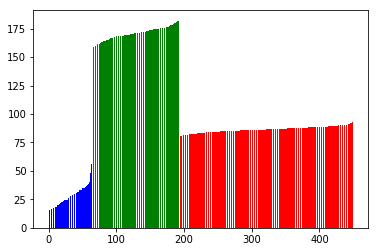

In [93]:
plotMEConvolution(MEConvMat[0], MEConvMat[1], MEConvMat[2])

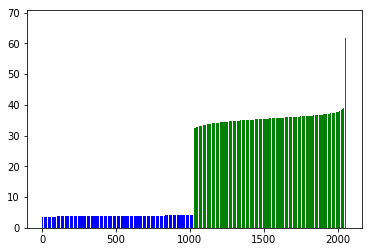

In [94]:
plotMEFullyConnected(MEFullyConnectedMat[0], MEFullyConnectedMat[1], MEFullyConnectedMat[2])

In [96]:
print(MEFullyConnectedMat[2])

[56.22157299 56.22157368 61.72141022 61.72141037 62.96027309 62.96027328
 65.23339203 65.23339256 67.35180061 67.35180088]
